*Efrat Magidov, Dana Rozenblum, Doreen Ben-Zvi*
# Phising Email Detection

## Introduction

In recent times, a phishing attack has become one of the most prominent attacks faced by internet users, governments, and service-providing organizations. In a phishing attack, the attacker(s) collects the client’s sensitive data (i.e., user account login details, credit/debit card numbers, etc.) by using spoofed emails or fake websites. Phishing websites are common entry points of online social engineering attacks, including numerous frauds on the websites. In such types of attacks, the attacker(s) create website pages by copying the behavior of legitimate websites and sends URL(s) to the targeted victims through spam messages, texts, or social networking

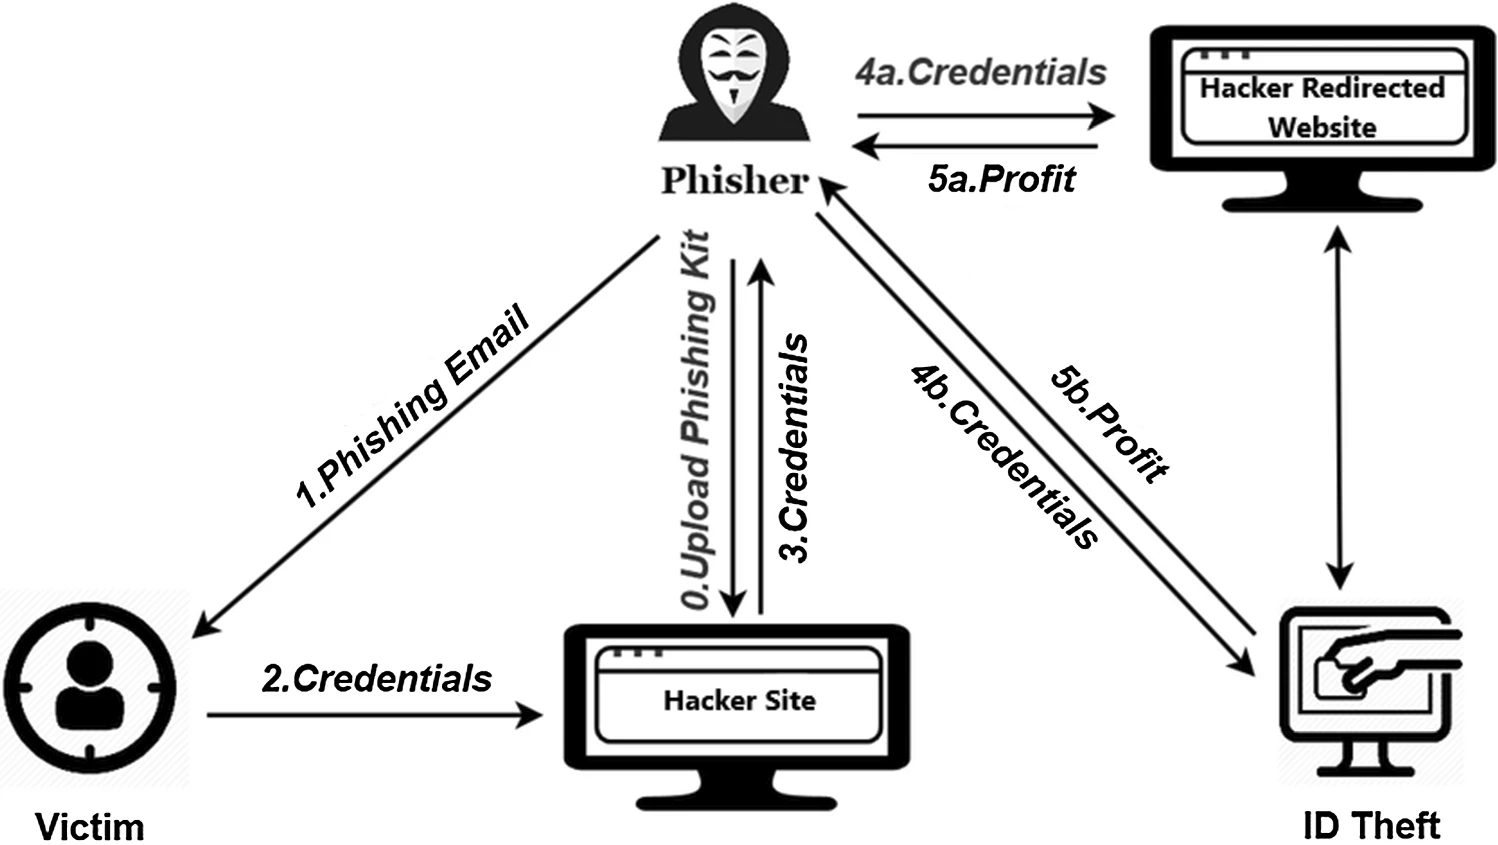
Phishing attack diagram [Forecast. (2017). Global fraud and cybercrime forecast. https://www.rsa.com/en-us/blog/2016-12/2017-global-fraud-cybercrime-forecast.]

In this project we aimed to use state of the art machine learning tools for detection of spoofing emails.

## Libraries

In [368]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import re
import optuna
import timeit
import pickle
import sys

from sklearn.exceptions import NotFittedError
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score,roc_curve, \
                            confusion_matrix, recall_score, precision_score, \
                            precision_recall_curve,classification_report, f1_score, make_scorer
from sklearn.preprocessing import binarize, PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve
from sklearn.pipeline import make_pipeline
from sklearn.utils import class_weight, resample
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
%matplotlib inline
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from collections import Counter
import nltk

## Create Functions

In [203]:
# define a function to print accuracy metrics
def print_accuracy_metrics(Input,Output):
    print("Recall:", recall_score(Input, Output))
    print("Log Loss:", log_loss(Input, Output))
    print("Precision:", precision_score(Input, Output))
    print("Accurcay:", accuracy_score(Input, Output))
    print("AUC: ", roc_auc_score(Input, Output))
    print("F1 Score:", f1_score(Input, Output))
    confusion_matrix_value = confusion_matrix(Input,Output)
    print('Confusion matrix:\n', confusion_matrix_value)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame( confusion_matrix_value), annot=True, cmap="Blues" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    

In [4]:
def confusion_plot(matrix, labels=None):
    """ Display binary confusion matrix as a Seaborn heatmap """
    
    labels = labels if labels else ['Negative (0)', 'Positive (1)']
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    sns.heatmap(data=matrix, cmap='Blues', annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    ax.set_title('Confusion Matrix')
    plt.close()
    
    return fig

In [5]:
# defined a function to print cross validation score
scoring = {'recall' : make_scorer(recall_score)}
def cross_validation_metrics(log_reg, X, y):
    log_reg_score = cross_val_score(log_reg, X,y,cv=5,scoring='recall')
    print('Logistic Regression Cross Validation Score(Recall): ', round(log_reg_score.mean() * 100, 2)
          .astype(str) + '%')

In [6]:
# function for plotting feature importance
def feature_importance(model, X):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
               axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
      print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [7]:
# function to draw ROC curve
def roc_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Receiver Operating Characteristic (ROC) curve 
        Set `compare=True` to use this function to compare classifiers. """
    
    fpr, tpr, thresh = roc_curve(y_true, y_probs,
                                 drop_intermediate=False)
    auc = round(roc_auc_score(y_true, y_probs), 2)
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    label = ' '.join([label, f'({auc})']) if compare else None
    sns.lineplot(x=fpr, y=tpr, ax=axis, label=label)
    
    if compare:
        axis.legend(title='Classifier (AUC)', loc='lower right')
    else:
        axis.text(0.72, 0.05, f'AUC = { auc }', fontsize=12,
                  bbox=dict(facecolor='green', alpha=0.4, pad=5))
            
        # Plot No-Info classifier
        axis.fill_between(fpr, fpr, tpr, alpha=0.3, edgecolor='g',
                          linestyle='--', linewidth=2)
        
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('ROC Curve')
    axis.set_xlabel('False Positive Rate [FPR]\n(1 - Specificity)')
    axis.set_ylabel('True Positive Rate [TPR]\n(Sensitivity or Recall)')
    
    plt.close()
    
    return axis if ax else fig

In [312]:
def precision_recall_plot(y_true, y_probs, label, compare=False, ax=None):
    """ Plot Precision-Recall curve.
        Set `compare=True` to use this function to compare classifiers. """
    
    p, r, thresh = precision_recall_curve(y_true, y_probs)
    f1 = 2*r*p/(r+p)
    p, r, thresh, f1 = list(p), list(r), list(thresh), list(f1)
    p.pop()
    r.pop()
    f1.pop()
    
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1)
    
    if compare:
        sns.lineplot(r, p, ax=axis, label=label)
        axis.set_xlabel('Recall')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')
    else:
        sns.lineplot(thresh, p, label='Precision', ax=axis)
        axis.set_xlabel('Threshold')
        axis.set_ylabel('Precision')
        axis.legend(loc='lower left')

        axis_twin = axis.twinx()
        sns.lineplot(thresh, r, color='limegreen', label='Recall', ax=axis_twin)
        axis_twin.set_ylabel('Recall')
        axis_twin.set_ylim(0, 1)
        axis_twin.legend(bbox_to_anchor=(0.24, 0.18))
        
        sns.lineplot(thresh, f1, color='red', label='F1', ax=axis_twin)
        axis_twin.set_ylabel('F1')
        axis_twin.set_ylim(0, 1)
        axis_twin.legend(bbox_to_anchor=(0.24, 0.18))
    
    axis.set_xlim(0, 1)
    axis.set_ylim(0, 1)
    axis.set_title('Precision Vs Recall')
    
    plt.close()
    
    return axis if ax else fig

In [638]:
def feature_importance_plot(importances, feature_labels, ax=None):
    fig, axis = (None, ax) if ax else plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
    sns.barplot(x=importances, y=feature_labels, ax=axis)
    axis.set_title('Feature Importance')
    
    plt.close()
    
    return axis if ax else fig

In [10]:
def train_clf(clf, x_train, y_train, sample_weight=None, refit=False):
    train_time = 0
    
    try:
        if refit:
            raise NotFittedError
        y_pred_train = clf.predict(x_train)
    except NotFittedError:
        start = timeit.default_timer()
        
        if sample_weight is not None:
            clf.fit(x_train, y_train, sample_weight=sample_weight)
        else:
            clf.fit(x_train, y_train)
        
        end = timeit.default_timer()
        train_time = end - start
        
        y_pred_train = clf.predict(x_train)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    return clf, y_pred_train, train_acc, train_time

In [11]:
def model_memory_size(clf):
    return sys.getsizeof(pickle.dumps(clf))

In [639]:
def report(clf, x_train, y_train, x_test, y_test, display_scores=[],
           sample_weight=None, refit=False, importance_plot=False,
           confusion_labels=None, feature_labels=None, verbose=True):
    """ Trains the passed classifier if not already trained and reports
        various metrics of the trained classifier """
    
    dump = dict()
    
    ## Train if not already trained
    clf, train_predictions, \
    train_acc, train_time = train_clf(clf, x_train, y_train,
                                      sample_weight=sample_weight,
                                      refit=refit)
    ## Testing
    start = timeit.default_timer()
    test_predictions = clf.predict(x_test)
    end = timeit.default_timer()
    test_time = end - start
    
    test_acc = accuracy_score(y_test, test_predictions)
    y_probs = clf.predict_proba(x_test)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_probs)
        
    ## Additional scores
    scores_dict = dict()
    for func in display_scores:
        scores_dict[func.__name__] = [func(y_train, train_predictions),
                                      func(y_test, test_predictions)]
        
    ## Model Memory
    model_mem = round(model_memory_size(clf) / 1024, 2)
    
    print(clf)
    print("\n=============================> TRAIN-TEST DETAILS <======================================")
    
    ## Metrics
    print(f"Train Size: {x_train.shape[0]} samples")
    print(f" Test Size: {x_test.shape[0]} samples")
    print("---------------------------------------------")
    print(f"Training Time: {round(train_time, 3)} seconds")
    print(f" Testing Time: {round(test_time, 3)} seconds")
    print("---------------------------------------------")
    print("Train Accuracy: ", train_acc)
    print(" Test Accuracy: ", test_acc)
    print("---------------------------------------------")
    
    if display_scores:
        for k, v in scores_dict.items():
            score_name = ' '.join(map(lambda x: x.title(), k.split('_')))
            print(f'Train {score_name}: ', v[0])
            print(f' Test {score_name}: ', v[1])
            print()
        print("---------------------------------------------")
    
    print(" Area Under ROC (test): ", roc_auc)
    print("---------------------------------------------")
    print(f"Model Memory Size: {model_mem} kB")
    print("\n=============================> CLASSIFICATION REPORT <===================================")
    
    ## Classification Report
    clf_rep = classification_report(y_test, test_predictions, output_dict=True)
    
    print(classification_report(y_test, test_predictions,
                                target_names=confusion_labels))
    
    
    if verbose:
        print("\n================================> CONFUSION MATRIX <=====================================")
    
        ## Confusion Matrix HeatMap
        display(confusion_plot(confusion_matrix(y_test, test_predictions),
                               labels=confusion_labels))
        print("\n=======================================> PLOTS <=========================================")


        ## Variable importance plot
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        roc_axes = axes[0, 0]
        pr_axes = axes[0, 1]
        importances = None

        if importance_plot:
            if not feature_labels:
                raise RuntimeError("'feature_labels' argument not passed "
                                   "when 'importance_plot' is True")

            try:
                importances = pd.Series(clf.feature_importances_,
                                        index=feature_labels) \
                                .sort_values(ascending=False)
            except AttributeError:
                try:
                    importances = pd.Series(clf.coef_.ravel(),
                                            index=feature_labels) \
                                    .sort_values(ascending=False)
                except AttributeError:
                    pass

            if importances is not None:
                # Modifying grid
                grid_spec = axes[0, 0].get_gridspec()
                for ax in axes[:, 0]:
                    ax.remove()   # remove first column axes
                large_axs = fig.add_subplot(grid_spec[0:, 0])

                # Plot importance curve
                feature_importance_plot(importances=importances.values,
                                        feature_labels=importances.index,
                                        ax=large_axs)
                large_axs.axvline(x=0)

                # Axis for ROC and PR curve
                roc_axes = axes[0, 1]
                pr_axes = axes[1, 1]
            else:
                # remove second row axes
                for ax in axes[1, :]:
                    ax.remove()
        else:
            # remove second row axes
            for ax in axes[1, :]:
                ax.remove()


        ## ROC and Precision-Recall curves
        clf_name = clf.__class__.__name__
        roc_plot(y_test, y_probs, clf_name, ax=roc_axes)
        precision_recall_plot(y_test, y_probs, clf_name, ax=pr_axes)

        fig.subplots_adjust(wspace=5)
        fig.tight_layout()
        display(fig)
    
    ## Dump to report_dict
    dump = dict(clf=clf, accuracy=[train_acc, test_acc], **scores_dict,
                train_time=train_time, train_predictions=train_predictions,
                test_time=test_time, test_predictions=test_predictions,
                test_probs=y_probs, report=clf_rep, roc_auc=roc_auc,
                model_memory=model_mem)
    
    return clf, dump

In [13]:
# error analysis
def error_analysis(orig_df, y_pred, y_true):
    type1_error_idx = np.intersect1d(np.argwhere(y_pred==1).T, np.argwhere(y_true.values==0).T)
    type2_error_idx = np.intersect1d(np.argwhere(y_pred==0).T, np.argwhere(y_true.values==1).T)

In [14]:
# make predictions for unlabeled data
def make_predictions_for_unlabeled(unlabeled_data_orig, unlabeled_data_extanded, model):
    y_pred = model.predict(unlabeled_data_extanded)
    preds_df = unlabeled_data_orig[['index']]
    preds_df['Label'] = y_pred
    preds_df.set_index('index',inplace=True)
    return preds_df

## Import Data

In [168]:
df = pd.read_csv('train_X.csv')
df_test = pd.read_csv('test_X.csv')
labels = pd.read_csv('train_y.csv')

print('Train data shape:')
print(df.shape)
print("Data columns:")
print(df.columns)

Train data shape:
(29390, 4)
Data columns:
Index(['index', 'Content', 'Subject', 'Content-Type'], dtype='object')


## EDA

In [169]:
df.head()

,index,Content,Subject,Content-Type
0,38679,What's Next for\nEnron Federal Credit Union\n\...,Credit Union Changes,text/plain;
1,15230,Go ahead and decline. She is in San Fran but a...,RE: Request Submitted: Access Request for mari...,text/plain;
2,2190,<DIV><BR><BR>\n<META http-equiv=DESCRIPTION co...,Unauthorized Access Report (Notice #21174),"text/html; charset=""Windows-1251"""
3,40336,\nRachael Owens\nAdmin. Assistant\nIcon Inform...,I got the timesheet..Thanks!,"multipart/alternative; boundary=""----_=_NextPa..."
4,13988,\n\n -----Original Message-----\nFrom: \tWrigh...,FW: Security Smart ID Tags-Off Property Usage,text/plain;


In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29390 entries, 0 to 29389
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         29390 non-null  int64 
 1   Content       29291 non-null  object
 2   Subject       28643 non-null  object
 3   Content-Type  28564 non-null  object
dtypes: int64(1), object(3)
memory usage: 918.6+ KB


In [171]:
# null values distribution in train data
null_data = df[df.isnull().any(axis=1)]
print('null by feature:')
print(df.isnull().sum())
print("Rows with null values are %.2f%% of the train data." %(100*len(null_data)/len(df)))

null by feature:
index             0
Content          99
Subject         747
Content-Type    826
dtype: int64
Rows with null values are 5.44% of the train data.


In [468]:
# check for duplicated rows
print(f'Subject duplicated values in train data: {df.Subject.duplicated().sum()}')
print(f'Content duplicated values in train data: {df.Content.duplicated().sum()}')
print(f'Subject duplicated values in test data: {df_test.Subject.duplicated().sum()}')
print(f'Content duplicated values in test data: {df_test.Content.duplicated().sum()}')

Subject duplicated values in train data: 7923
Content duplicated values in train data: 3714
Subject duplicated values in test data: 2583
Content duplicated values in test data: 1139


The dataset contains many duplicated values since it was manually sytheszed. We'll leave as is for now since the same dataset sythesis methos was applyed for the unlabeled test data.

In [173]:
labels.Label.value_counts()

0    26588
1     2802
Name: Label, dtype: int64

In [469]:
n_phishing = labels.Label.value_counts()[1]
n_nonphishing = labels.Label.value_counts()[0]
n_samples = df.shape[0]

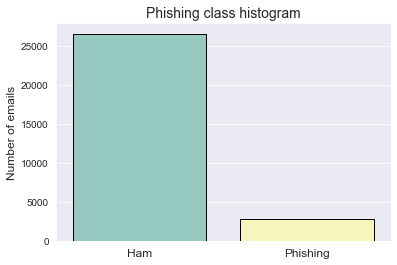

In [470]:
# Now lets check the class distributions
sns.set_style(style="darkgrid")
sns.countplot("Label", data=labels, 
              palette="Set3", edgecolor='k')
plt.title("Phishing class histogram", size=14)
plt.xlabel(None)
plt.xticks([0,1],['Ham', 'Phishing'], size=12)
plt.ylabel("Number of emails", size=12)
plt.show()

In [471]:
print('Phising emails are %.4f%% of the training data.' %(100*labels.Label.value_counts()[1]/len(df)))

Phising emails are 9.5339% of the training data.


The training dataset includes 29390 emails with 4 features: index, message content, subject content, and message content type. The labels are unbalanced - only about 10% of the training data are phising emails.

Given the special charachteristics of phishing emails, I expect to find some words more frequentky there than in ham emails. Such words are related to phishing attempts, trying to pursue the recipient to press on the phishing link.

In [483]:
# looking for most common words in phising emails' Subject 
stop_words = set(stopwords.words('english'))  

df['Subject_lower'] = df['Subject'].str.lower()
df = df.replace(np.nan, '', regex=True)
phish_words_subject = Counter(" ".join(df.loc[labels[labels['Label']==1].index,'Subject_lower']).split()).most_common(20)
most_common_words_phising_subject = [i[0] for i in phish_words_subject if not i[0] in stop_words]
most_common_words_phising_subject

['account',
 'ebay',
 'paypal',
 'update',
 '-',
 'notification',
 'security',
 'bank',
 'access',
 'limited',
 'online',
 'please',
 'question',
 '!',
 'information',
 'important']

In [478]:
# looking for most common words in ham emails' subject

ham_words_subject = Counter(" ".join(df.loc[labels[labels['Label']==0].index,'Subject_lower']).split()).most_common(20)
most_common_words_ham_subject = [i[0] for i in ham_words_subject if not i[0] in stop_words]
most_common_words_ham_subject


['re:',
 'fw:',
 '-',
 'hourahead',
 'start',
 'date:',
 'hour:',
 'enron',
 'meeting',
 'gas',
 'report',
 '2001',
 'schedule',
 'update']

In [487]:
# remove words that appear in both:
most_common_words_phising_subject_unique = [e for e in most_common_words_phising_subject if e not in most_common_words_ham_subject]
most_common_words_ham_subject_unique = [e for e in most_common_words_ham_subject if e not in most_common_words_phising_subject]

(Importantly, this is a rather quick and dirty way of identifting most common words. Ideally we should perform such feature extraction on text that is stemmed, tokenized, Ngramed and free from punctuatuon marks.)

Based on literature scan we know that link presence is a strong feature for phisihng emails. We'll focus on the links features for our model. We'll better extract the links using beautifulsoup and search for features based on the paper:

Akinyelu, A. A., & Adewumi, A. O. (2014). Classification of phishing email using random forest machine learning technique. Journal of Applied Mathematics, 2014.https://www.hindawi.com/journals/jam/2014/425731/.

## Preproccessing and Feature Extraction

In [29]:
# from the paper
Content_common_phish_words_1 = ['update','confirm']
Content_common_phish_words_2 = ['user','customer','client']
Content_common_phish_words_3 = ['suspend','restrict','hold']
Content_common_phish_words_4 = ['login', 'username', 'password', 'click', 'log']
Content_common_phish_words_5 = ['ssn','social security', 'secur', 'inconvinien']

In [30]:
# -*- coding: utf-8 -*-
def is_ascii(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:b
        return True

In [31]:
def get_links_with_ip(links_list):
    ip_reg = '^(http|https)://\d+\.\d+\.\d+\.\d+\.*'
    return sum(re.match(ip_reg,l.get('href')) is not None for l in links_list)

In [32]:
def get_links_text(links_list):
    text_in_links = []
    for t in links_list:
        text_in_links.append(t.text)
    return text_in_links

In [488]:
# define function for feature extraction

def feature_extraction(df, text_cols):
    # define null values features
    cols_with_missing_values = df.columns[df.isnull().any()].tolist()
    for miss_col in cols_with_missing_values:
        df[miss_col+'_missing'] = df[miss_col].isnull()
    # replace all missing values with empty string
    df = df.replace(np.nan, '', regex=True)
    # find if dtype is html
    df['html_dtype'] = df['Content-Type'].str.contains('html')
    # handle text data
    for text_col in text_cols:
        # make lower. if missing write 'missing'
        df[text_col+'_lower'] = df[text_col].apply(lambda x: x.lower())
        # count uppercase and lowercase
        df[text_col+'_Uppercase'] = df[text_col].str.findall(r'[A-Z]').str.len()
        df[text_col+'_Lowercase'] = df[text_col].str.findall(r'[a-z]').str.len()
        # text length
        df[text_col+'_length'] = df[text_col].str.len()
        # is english
        df[text_col+'_is_ascii'] = df[text_col+'_lower'].apply(is_ascii)
        # find links
        df[text_col+'_all_links'] = df[text_col+'_lower'].apply(lambda x: BeautifulSoup(x, 'lxml').find_all('a'))
        df[text_col+'_n_links'] = df[text_col+'_all_links'].apply(lambda x: len(x))
        df[text_col+'_links_presence'] = df[text_col+'_n_links']>0
        #df[text_col+'_n_links_with_ip'] =  df[text_col+'_all_links'].apply(get_links_with_ip)
        df[text_col+'_suspicious_words_in_links_text'] = df[text_col+'_all_links'].apply(
            lambda x: any(('click' or 'link' or 'here' or 'login' or 'update') 
                          in l for l in get_links_text(x)))
    #common words for phishing 
    df['Subject_phish_words'] = df['Subject_lower'].str.contains('|'.join(most_common_words_phising_subject_unique))
    df['Subject_ham_words'] = df['Subject_lower'].str.contains('|'.join(most_common_words_ham_subject_unique))
    df['Content_phish_words_1'] = df['Content_lower'].str.contains('|'.join(Content_common_phish_words_1))
    df['Content_phish_words_2'] = df['Content_lower'].str.contains('|'.join(Content_common_phish_words_2))
    df['Content_phish_words_3'] = df['Content_lower'].str.contains('|'.join(Content_common_phish_words_3))
    df['Content_phish_words_4'] = df['Content_lower'].str.contains('|'.join(Content_common_phish_words_4))
    df['Content_phish_words_5'] = df['Content_lower'].str.contains('|'.join(Content_common_phish_words_5))
    
    return df


In [489]:
df_extanded = feature_extraction(df, ['Content','Subject'])

In [490]:
df_extanded.columns

Index(['index', 'Content', 'Subject', 'Content-Type', 'Content_missing',
       'Subject_missing', 'Content-Type_missing', 'Content_lower', 'Label',
       'Subject_lower', 'html_dtype', 'Content_Uppercase', 'Content_Lowercase',
       'Content_length', 'Content_is_english', 'Content_all_links',
       'Content_n_links', 'Content_links_presence',
       'Content_suspicious_words_in_links_text', 'Subject_Uppercase',
       'Subject_Lowercase', 'Subject_length', 'Subject_is_english',
       'Subject_all_links', 'Subject_n_links', 'Subject_links_presence',
       'Subject_suspicious_words_in_links_text', 'Subject_phish_words',
       'Subject_ham_words', 'Content_phish_words_1', 'Content_phish_words_2',
       'Content_phish_words_3', 'Content_phish_words_4',
       'Content_phish_words_5'],
      dtype='object')

In [493]:
# remove columns that are not features for the model
cols_to_drop = ['index','Content','Subject','Content-Type',
                'Content_lower','Content_all_links',
                'Subject_lower','Subject_all_links']
X = df_extanded.drop(cols_to_drop, axis=1)
y = labels['Label']

In [506]:
df_test_extanded = feature_extraction(df_test, ['Content','Subject'])
X_unlabeled_test = df_test_extanded.drop(cols_to_drop, axis=1)

## Compare several classification models

In [494]:
# Define dictionary with performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}

# Instantiate the machine learning classifiers
log_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
svc_model = make_pipeline(StandardScaler(), SVC())
dtr_model = DecisionTreeClassifier()
rfc_model = RandomForestClassifier()
gnb_model = GaussianNB()
xgb_model = XGBClassifier(eval_metric='error')
adb_model = AdaBoostClassifier(n_estimators=100)

# Define the models evaluation function
def models_evaluation(X, y, folds):
    
    '''
    X : data set features
    y : data set target
    folds : number of cross-validation folds
    
    '''
    
    # Perform cross-validation to each machine learning classifier
    log = cross_validate(log_model, X, y, cv=folds, scoring=scoring)
    svc = cross_validate(svc_model, X, y, cv=folds, scoring=scoring)
    dtr = cross_validate(dtr_model, X, y, cv=folds, scoring=scoring)
    rfc = cross_validate(rfc_model, X, y, cv=folds, scoring=scoring)
    gnb = cross_validate(gnb_model, X, y, cv=folds, scoring=scoring)
    xgb = cross_validate(xgb_model, X, y, cv=folds, scoring=scoring)
    adb = cross_validate(adb_model, X, y, cv=folds, scoring=scoring)

    # Create a data frame with the models perfoamnce metrics scores
    models_scores_table = pd.DataFrame({'Logistic Regression':[log['test_accuracy'].mean(),
                                                               log['test_precision'].mean(),
                                                               log['test_recall'].mean(),
                                                               log['test_f1_score'].mean()],
                                       
                                      'Support Vector Classifier':[svc['test_accuracy'].mean(),
                                                                   svc['test_precision'].mean(),
                                                                   svc['test_recall'].mean(),
                                                                   svc['test_f1_score'].mean()],
                                       
                                      'Decision Tree':[dtr['test_accuracy'].mean(),
                                                       dtr['test_precision'].mean(),
                                                       dtr['test_recall'].mean(),
                                                       dtr['test_f1_score'].mean()],
                                       
                                      'Random Forest':[rfc['test_accuracy'].mean(),
                                                       rfc['test_precision'].mean(),
                                                       rfc['test_recall'].mean(),
                                                       rfc['test_f1_score'].mean()],
                                       
                                      'Gaussian Naive Bayes':[gnb['test_accuracy'].mean(),
                                                              gnb['test_precision'].mean(),
                                                              gnb['test_recall'].mean(),
                                                              gnb['test_f1_score'].mean()],
                                       
                                       'XGBoost Classifier':[xgb['test_accuracy'].mean(),
                                                             xgb['test_precision'].mean(),
                                                             xgb['test_recall'].mean(),
                                                             xgb['test_f1_score'].mean()],
                                       
                                       'AdABoost Classifier':[adb['test_accuracy'].mean(),
                                                             adb['test_precision'].mean(),
                                                             adb['test_recall'].mean(),
                                                             adb['test_f1_score'].mean()]},
                                      
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)
  
# Run models_evaluation function
models_evaluation(X, y, 5)

,Logistic Regression,Support Vector Classifier,Decision Tree,Random Forest,Gaussian Naive Bayes,XGBoost Classifier,AdABoost Classifier,Best Score
Accuracy,0.989044,0.993807,0.992310,0.995509,0.961994,0.995475,0.989350,Random Forest
Precision,0.958997,0.975401,0.958833,0.983745,0.742846,0.984416,0.958844,XGBoost Classifier
Recall,0.925064,0.959317,0.960741,0.968950,0.930779,0.967881,0.928634,Random Forest
F1 Score,0.941476,0.967261,0.959743,0.976250,0.825130,0.976054,0.943207,Random Forest


Although the data is imbalanced, the models (besides NB) perform well due to the domain specific feature extraction. Therefore we will not perform resampling or apply cost sensitive approach.

Most models demonstrate close to perfect performance. Therefor it will be hard to optimize it.

We'll persue with Random Forest which gives overall (slightly) better performance than the rest of the classifiers.

## Focus on Random Forest

In [614]:
# train-validation-test split
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [615]:
primary_eval_metric = metrics.f1_score
confusion_lbs = ['Ham', 'Phishing']

RandomForestClassifier(random_state=0)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 22042 samples
 Test Size: 4408 samples
---------------------------------------------
Training Time: 0 seconds
 Testing Time: 0.082 seconds
---------------------------------------------
Train Accuracy:  1.0
 Test Accuracy:  0.9959165154264973
---------------------------------------------
Train F1 Score:  1.0
 Test F1 Score:  0.9795454545454545

---------------------------------------------
 Area Under ROC (test):  0.9981201198978649
---------------------------------------------
Model Memory Size: 3188.71 kB

=============================> CLASSIFICATION REPORT <===================================
              precision    recall  f1-score   support

         Ham       1.00      1.00      1.00      3965
    Phishing       0.99      0.97      0.98       443

    accuracy                           1.00      4408
   macro avg       0.99      0.99    

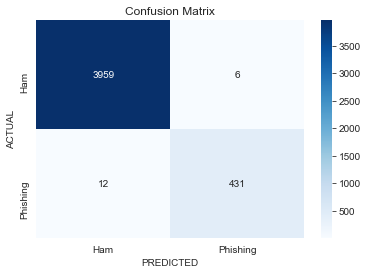


=======================================> PLOTS <=========================================


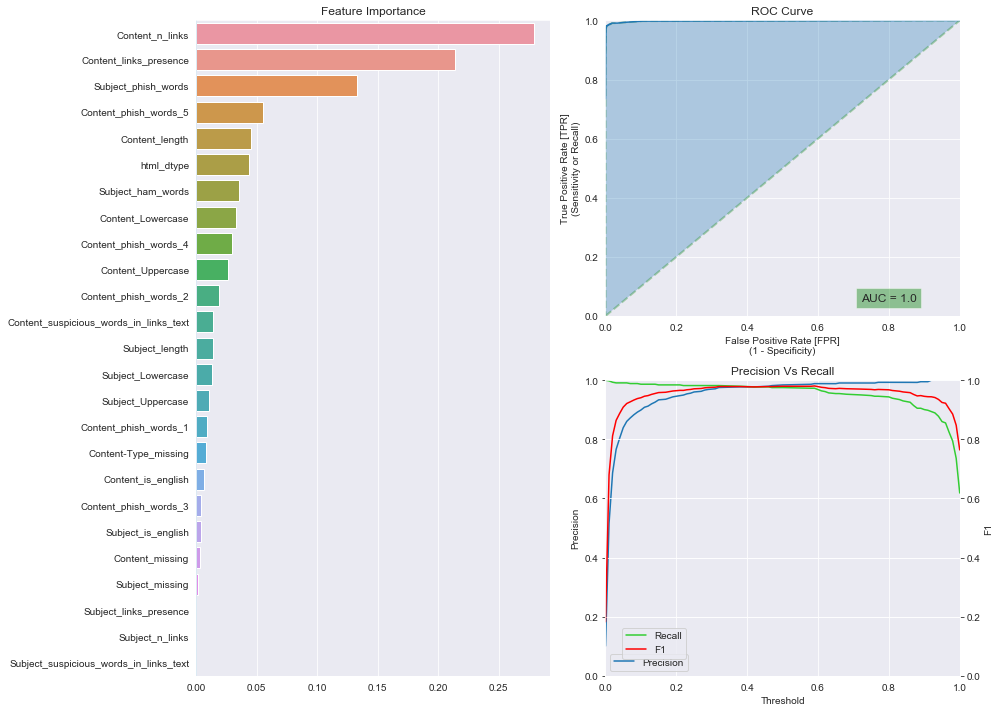

In [640]:
# Random Forest with deafult settings
rf_clf_deafult = RandomForestClassifier(random_state=0)
rf_clf_deafult.fit(X_train, y_train)

rf_clf_deafult, rf_report_deafult = report(rf_clf_deafult, X_train, y_train,
                                             X_val, y_val,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=X_train.columns.tolist(),
                                             confusion_labels=confusion_lbs)


### Feature selection: drop features that don't help prediction

There are known problems with the impurity-based feature importance of random forests: the importances can be high even for features that are not predictive of the target variable, as long as the model has the capacity to use them to overfit. Moreover this method tends to inflate the importance of continuous features, which explains the high place the "number of links" feature takes. 

Let's compute permutation based feature importance and compare to our results(https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)

In [641]:
r = permutation_importance(rf_clf_deafult,X_val,y_val)

In [642]:
sorted_idx = r.importances_mean.argsort()

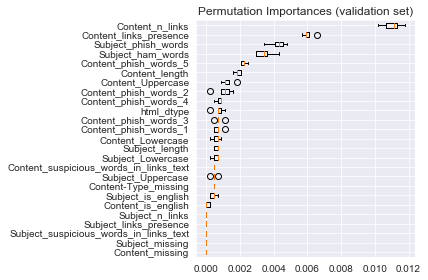

In [644]:
fig, ax = plt.subplots()
ax.boxplot(r.importances[sorted_idx].T,
           vert=False, labels=X_val.columns[sorted_idx])
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

We see that the two methods give similar results.

We'll drop features that don't help the classification.

In [697]:
features_to_drop = ['Subject_links_presence', 'Subject_n_links', 'Subject_suspicious_words_in_links_text']

In [698]:
X_feature_selection, X_unlabeled_test_feature_selection = \
                                    X.drop(columns=features_to_drop), \
                                    X_unlabeled_test.drop(columns=features_to_drop)

## Error analysis: 

In [684]:
# train-validation-test split
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X_feature_selection, y, test_size=1 - train_ratio)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [685]:
rf_clf_deafult.fit(X_train, y_train)
y_preds = rf_clf_deafult.predict(X_val)

In [686]:
type1_error_idx = np.intersect1d(np.argwhere(y_preds==1).T, np.argwhere(y_val.values==0).T)
type2_error_idx = np.intersect1d(np.argwhere(y_preds==0).T, np.argwhere(y_val.values==1).T)

In [687]:
type1_error_idx.shape, type2_error_idx.shape

((8,), (7,))

In [688]:
X_val.iloc[type1_error_idx] # ham classified as phishing

,Content-Type_missing,html_dtype,Content_Uppercase,Content_Lowercase,Content_length,Content_is_english,Content_n_links,Content_links_presence,Content_suspicious_words_in_links_text,Subject_Uppercase,Subject_Lowercase,Subject_length,Subject_is_english,Subject_phish_words,Subject_ham_words,Content_phish_words_1,Content_phish_words_2,Content_phish_words_3,Content_phish_words_4,Content_phish_words_5
6104,False,True,52,729,1085,True,3,True,False,5,38,48,True,False,False,True,False,True,False,False
15899,False,False,23,292,514,True,1,True,True,3,11,19,True,True,True,False,True,False,True,False
12343,False,True,71,1987,3215,False,3,True,True,4,40,51,True,True,False,False,True,False,True,False
5583,False,True,142,2491,4675,True,11,True,False,6,14,28,True,True,False,False,False,False,True,True
20374,False,False,188,1981,2973,True,3,True,True,3,20,26,True,False,False,False,True,False,True,False
24913,False,True,862,2916,8407,False,4,True,True,7,16,29,True,False,False,False,True,False,True,False
8585,False,True,214,780,1439,True,1,True,False,9,48,69,True,False,False,False,False,False,True,False
24493,False,False,154,176,509,True,1,True,False,3,26,41,True,False,True,False,False,False,False,False


In [689]:
print('Ham classified as Phising:')
for doc in enumerate(df_extanded.loc[X_val.iloc[type1_error_idx].index,'Subject']):
    print(doc)

Ham classified as Phising:
(0, "Revisions to TransCanada's Transportation Tariff")
(1, 'FW: Check this out!')
(2, 'Customize your Energy Central Direct account today!')
(3, 'Yahoo! Bill Pay - New E-Bill')
(4, 'Breaking news from NewsMax')
(5, 'Outsourcing CIS - A Good Move')
(6, "Fwd: Thank you for your submission to CSC's CareerSource Job Database")
(7, 'FW: Turn the speakers on for this one....')


In [690]:
X_val.iloc[type2_error_idx] # phishing classified as ham

,Content-Type_missing,html_dtype,Content_Uppercase,Content_Lowercase,Content_length,Content_is_english,Content_n_links,Content_links_presence,Content_suspicious_words_in_links_text,Subject_Uppercase,Subject_Lowercase,Subject_length,Subject_is_english,Subject_phish_words,Subject_ham_words,Content_phish_words_1,Content_phish_words_2,Content_phish_words_3,Content_phish_words_4,Content_phish_words_5
23917,True,False,9,74,119,True,0,False,False,6,33,45,True,True,False,False,False,False,False,False
26279,False,False,43,2525,3321,True,0,False,False,5,12,26,True,True,False,False,True,False,False,False
19032,False,False,24,596,809,False,0,False,False,2,7,17,True,True,False,False,True,False,True,True
4618,False,False,47,2575,3410,True,0,False,False,3,29,48,True,True,False,False,True,False,False,False
7305,False,False,47,103,235,True,0,False,False,2,10,13,True,True,False,False,False,False,False,False
8312,False,False,32,381,611,True,0,False,False,4,39,52,True,True,False,True,False,False,True,False
7884,False,False,34,530,693,True,0,False,False,44,0,49,True,True,False,False,True,True,False,False


In [691]:
print('Phising classified as Ham:')
for doc in enumerate(df_extanded.loc[X_val.iloc[type2_error_idx].index,'Subject']):
    print(doc)

Phising classified as Ham:
(0, 'In Reference to Your February Account Summary')
(1, 'Paypal; Received $2,000USD')
(2, 'Get $50 Survey!!!')
(3, 'Pay.Pal. Your account has been credited $2887.89')
(4, 'Please Verify')
(5, 'National Australia Bank: Forced security measures.!!')
(6, 'BANESTO INFORMACION IMPORTANTE SOBRE SU SEGURIDAD')


Conclusions from the quick error inspection:
- Seems like the feature checking for presence of suspiciois words in the email's subject (e.g bank, account) should get more weight. 
- re:/fwd: can appear also in phising emails so including them in ham words feature is not optimal.
- many of the misclassified hams contain '!' so better remove it from phish word list.

## Optimization with Optuna on the validation set

In [544]:
def objective(trial):
    
    X, y = X_val, y_val

    list_trees = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250]
    
    # 2. Suggest values for the hyperparameters using a trial object.
    rf_max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    rf_n_estimators = trial.suggest_categorical('n_estimators', list_trees)
    rf_max_features = trial.suggest_uniform('max_features', 0.15, 1.0)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 14)
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 14)
    rf_max_samples = trial.suggest_uniform('max_samples', 0.6, 0.99)

    classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_n_estimators,
                     max_features=rf_max_features, min_samples_split=rf_min_samples_split,
                     min_samples_leaf=rf_min_samples_leaf, max_samples=rf_max_samples,
                     bootstrap=True, n_jobs=-1, verbose=0)

    mean_cv_score = cross_val_score(classifier_obj, X, y,
                                        scoring='f1', 
                                        cv=10, n_jobs=-1).mean()
    
    return mean_cv_score
        
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2021-01-30 14:36:18,429] A new study created in memory with name: no-name-94a8bb20-b2a2-4e19-9c8e-7052292ee274
[I 2021-01-30 14:36:25,915] Trial 0 finished with value: 0.9389794165834676 and parameters: {'max_depth': 29, 'n_estimators': 175, 'max_features': 0.49727293776754844, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_samples': 0.6296221444900474}. Best is trial 0 with value: 0.9389794165834676.
[I 2021-01-30 14:36:28,710] Trial 1 finished with value: 0.9348375885512239 and parameters: {'max_depth': 2, 'n_estimators': 150, 'max_features': 0.34839978650318876, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_samples': 0.6761741784233002}. Best is trial 0 with value: 0.9389794165834676.
[I 2021-01-30 14:36:32,219] Trial 2 finished with value: 0.9336147624759661 and parameters: {'max_depth': 7, 'n_estimators': 125, 'max_features': 0.6434525497474615, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_samples': 0.7988829393542969}. Best is trial 0 with value: 0.93897941

In [545]:
study.best_params

{'max_depth': 13,
 'n_estimators': 25,
 'max_features': 0.9559954599730994,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 0.9737469890882202}

RandomForestClassifier(max_depth=13, max_features=0.9559954599730994,
                       max_samples=0.9737469890882202, n_estimators=25,
                       random_state=0)

=============================> TRAIN-TEST DETAILS <======================================
Train Size: 22042 samples
 Test Size: 2940 samples
---------------------------------------------
Training Time: 0 seconds
 Testing Time: 0.015 seconds
---------------------------------------------
Train Accuracy:  0.9992741130568914
 Test Accuracy:  0.9959183673469387
---------------------------------------------
Train F1 Score:  0.996235294117647
 Test F1 Score:  0.9764705882352941

---------------------------------------------
 Area Under ROC (test):  0.9992405155730821
---------------------------------------------
Model Memory Size: 499.42 kB

=============================> CLASSIFICATION REPORT <===================================
              precision    recall  f1-score   support

         Ham       1.00      1

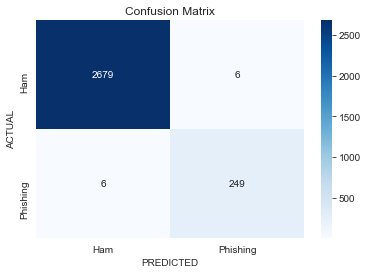


=======================================> PLOTS <=========================================


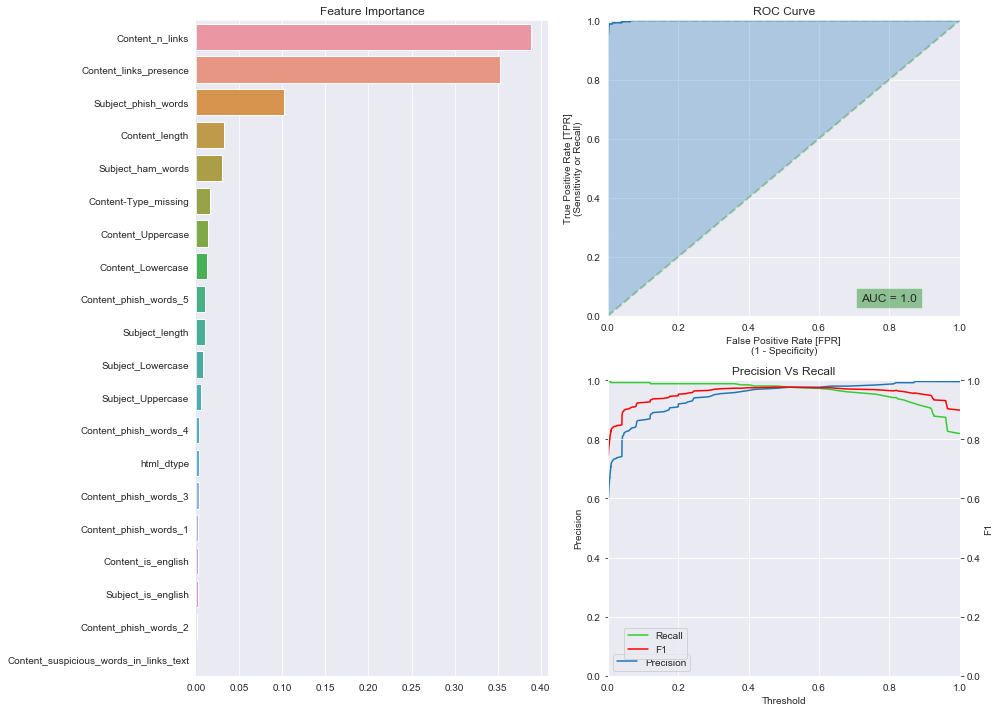

In [693]:
# use optimized parameters (on the validation set) for the test set
rf_clf_tuned = RandomForestClassifier(random_state=0, **study.best_params)
rf_clf_tuned.fit(X_train, y_train)

rf_clf_tuned, rf_report_tuned = report(rf_clf_tuned, X_train, y_train,
                                             X_test, y_test,
                                             display_scores=[primary_eval_metric],
                                             importance_plot=True,
                                             feature_labels=X_train.columns.tolist(),
                                             confusion_labels=confusion_lbs)

In [694]:
submission_8 = make_predictions_for_unlabeled(df_test, X_unlabeled_test_feature_selection, rf_clf_tuned)

In [696]:
submission_8.to_csv('submission_8.csv')